In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, datasets

In [13]:
EPOCHS = 100
BATCH_SIZE = 128
ETA = 1e-4

In [4]:
trainset, testset = datasets.mnist.load_data()

In [5]:
trainloader = tf.data.Dataset.from_tensor_slices(trainset).batch(BATCH_SIZE).shuffle(1024)
testloader = tf.data.Dataset.from_tensor_slices(testset).batch(BATCH_SIZE)

In [6]:
class Generator(models.Model):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.generator = models.Sequential([
            
            layers.Conv2DTranspose(64, (3, 3), strides=2, padding="VALID", output_padding=1), # 4
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(32, (3, 3), strides=2, padding="SAME", output_padding=0), # 7
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(16, (3, 3), strides=2, padding="SAME", output_padding=1), # 14
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(1, (3, 3), strides=2, padding="SAME", output_padding=1), # 28
            layers.Activation(tf.nn.sigmoid),
        ])
        
    def call(self, noise, latent_code, training=False):
        n = tf.shape(noise)[0]
        
        latent = tf.concat([noise, latent_code], axis=-1)
        latent = tf.reshape(latent, shape=(n, 1, 1, -1))
        
        x_generated = self.generator(latent, training=training)
        
        return x_generated

In [7]:
class Discriminator(models.Model):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.features = models.Sequential([
            layers.Conv2D(32, (3, 3), strides=2, padding="SAME"), # 14
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(64, (3, 3), strides=2, padding="SAME"), # 7
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(128, (3, 3), strides=2, padding="SAME"), # 4
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
        ])
        
        self.discriminator = models.Sequential([
            layers.Conv2D(1, (4, 4), strides=1, padding="VALID"), # 1
            layers.Activation(tf.nn.sigmoid),
            layers.Flatten(),
        ])
        
        self.Q = models.Sequential([
            layers.Conv2D(64, (4, 4), strides=1, padding="VALID"), # 1
            layers.Flatten()
        ])
        
    def call(self, x, training=False):
        n = tf.shape(x)[0]
        
        x = self.features(x, training=training)
        d = self.discriminator(x, training=training)
        latent = self.Q(x, training=training)
        
        return d, latent

In [8]:
def plot(reconstructed):
    plt.figure(figsize=(16, 2))
    
    for i, index in enumerate(np.random.choice(np.arange(tf.shape(reconstructed)[0]), replace=False, size=8)):
        img = reconstructed[i].numpy()*256
        img = img.astype(np.uint8).squeeze()
    
        plt.subplot(1, 8, i+1)
        plt.imshow(img, cmap="gray")
        plt.xticks([])
        plt.yticks([])
        
    plt.show()

In [14]:
def train():
    generator = Generator()
    discriminator = Discriminator()
    
    optimizer_gen = optimizers.Adam(learning_rate=ETA)
    optimizer_dis = optimizers.Adam(learning_rate=ETA)
    optimizer_info = optimizers.Adam(learning_rate=ETA)
    
    loss_be = losses.BinaryCrossentropy()
    loss_mse = losses.MeanSquaredError()
    
    train_loss_metric_gen = metrics.Mean()
    train_loss_metric_dis = metrics.Mean()
    test_loss_metric_gen = metrics.Mean()
    test_loss_metric_dis = metrics.Mean()
    
    for e in range(EPOCHS):
        
        for x, y in trainloader:
            x = tf.cast(x, dtype=tf.float32)/256
            x = tf.expand_dims(x, -1)
            y = tf.cast(y, dtype=tf.float32)
            
            n = tf.shape(x)[0]
            
            noise = tf.random.normal((n, 64))
            latent_code = tf.random.normal((n, 64))
            
            # train generator
            with tf.GradientTape() as tape_gen:
                x_generated = generator(noise, latent_code, training=True)
                d, latent_fake = discriminator(x_generated, training=True)
                loss_gen = loss_be(tf.ones((n,)), d) + loss_mse(latent_code, latent_fake)
                
            grads_gen = tape_gen.gradient(loss_gen, generator.trainable_variables)
            optimizer_gen.apply_gradients(zip(grads_gen, generator.trainable_variables))
            
            train_loss_metric_gen.update_state(loss_gen)
            
            with tf.GradientTape() as tape_dis:
                d_real, latent_real = discriminator(x, training=True)
                d_fake, latent_fake = discriminator(x_generated, training=True)
                loss_dis = loss_be(tf.ones((n,)), d_real) + loss_be(tf.zeros((n,)), d_fake) + loss_mse(latent_code, latent_fake)
                
            grads_dis = tape_dis.gradient(loss_dis, discriminator.trainable_variables)
            optimizer_dis.apply_gradients(zip(grads_dis, discriminator.trainable_variables))
            
            train_loss_metric_gen.update_state(loss_gen)
            train_loss_metric_dis.update_state(loss_dis)
            
        for x, y in testloader:
            x = tf.cast(x, dtype=tf.float32)/256
            x = tf.expand_dims(x, -1)
            y = tf.cast(y, dtype=tf.float32)
            
            n = tf.shape(x)[0]
            
            noise = tf.random.normal((n, 64))
            latent_code = tf.random.normal((n, 64))
            
            x_generated = generator(noise, latent_code, training=False)
            d_real, latent_real = discriminator(x, training=False)
            d_fake, latent_fake = discriminator(x_generated, training=False)
            
            loss_gen = loss_be(tf.ones((n,)), d_fake)
            loss_dis = loss_be(tf.ones((n,)), d_real) + loss_be(tf.zeros((n,)), d_fake) \
                    + loss_mse(latent_code, latent_real)
            
            test_loss_metric_gen.update_state(loss_gen)
            test_loss_metric_dis.update_state(loss_dis)
            
        if e == 0 or (e+1)%10 == 0:
            print(f"Epochs {e+1}/{EPOCHS}")
            print(f"Train loss of generator: {train_loss_metric_gen.result():.6f}")
            print(f"Train loss of discriminator: {train_loss_metric_dis.result():.6f}")
            print(f"Test loss of generator: {test_loss_metric_gen.result():.6f}")
            print(f"Test loss of discriminator: {test_loss_metric_dis.result():.6f}")
            plot(x_generated)

        train_loss_metric_gen.reset_states()
        train_loss_metric_dis.reset_states()
        test_loss_metric_gen.reset_states()
        test_loss_metric_dis.reset_states()

Epochs 1/100
Train loss of generator: 5.962611
Train loss of discriminator: 0.933500
Test loss of generator: 5.154709
Test loss of discriminator: 2.417578


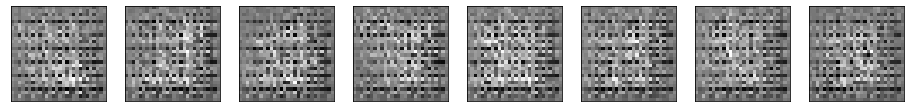

Epochs 10/100
Train loss of generator: 6.045379
Train loss of discriminator: 0.740031
Test loss of generator: 1.063556
Test loss of discriminator: 3.656512


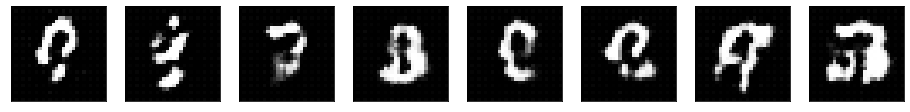

Epochs 20/100
Train loss of generator: 4.550727
Train loss of discriminator: 0.981025
Test loss of generator: 7.823343
Test loss of discriminator: 5.574618


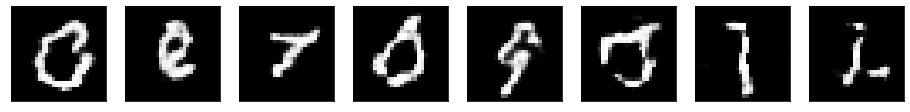

Epochs 30/100
Train loss of generator: 4.411565
Train loss of discriminator: 1.007445
Test loss of generator: 5.965500
Test loss of discriminator: 4.240937


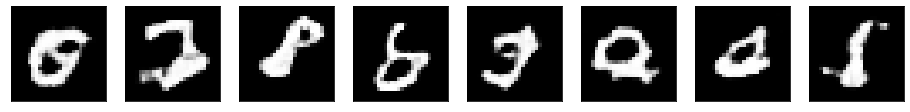

Epochs 40/100
Train loss of generator: 4.675536
Train loss of discriminator: 0.978584
Test loss of generator: 2.097943
Test loss of discriminator: 1.905506


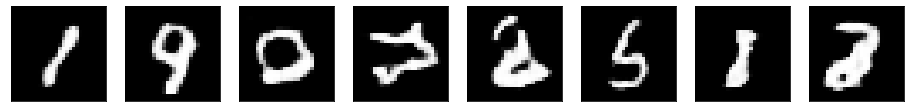

Epochs 50/100
Train loss of generator: 5.058684
Train loss of discriminator: 0.949769
Test loss of generator: 2.818881
Test loss of discriminator: 2.076524


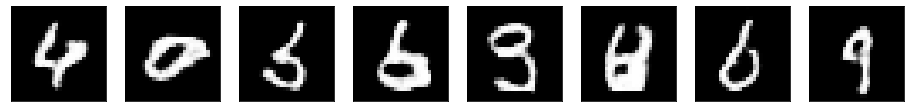

Epochs 60/100
Train loss of generator: 5.508501
Train loss of discriminator: 0.940755
Test loss of generator: 6.401331
Test loss of discriminator: 4.503814


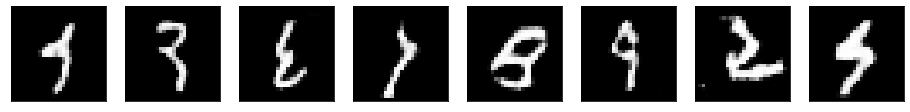

Epochs 70/100
Train loss of generator: 5.440232
Train loss of discriminator: 0.955911
Test loss of generator: 3.541196
Test loss of discriminator: 2.336952


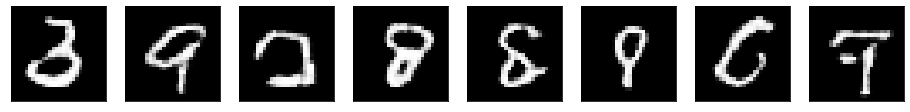

Epochs 80/100
Train loss of generator: 5.983357
Train loss of discriminator: 0.929668
Test loss of generator: 6.455387
Test loss of discriminator: 4.524727


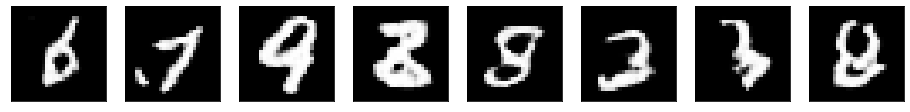

Epochs 90/100
Train loss of generator: 6.101512
Train loss of discriminator: 0.951758
Test loss of generator: 0.220610
Test loss of discriminator: 3.615188


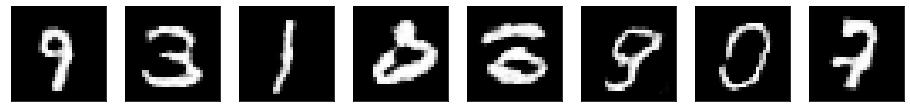

Epochs 100/100
Train loss of generator: 6.475575
Train loss of discriminator: 0.902450
Test loss of generator: 0.206392
Test loss of discriminator: 3.696833


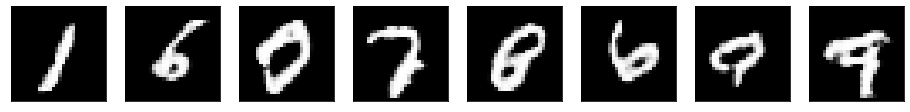

In [15]:
train()